In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.

testing_set = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
training_set, validation_set = torch.utils.data.random_split(datasets.MNIST(root='data', train=True, download=True, transform=ToTensor()), [50000,10000])

testing_dataloader = DataLoader(testing_set, batch_size=64, shuffle=True)
training_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=64, shuffle=True)

In [123]:
class DefaultNeuralNetwork(torch.nn.Module):
  # NeuralNetwork is taken from IntroductionToPyTorch example
  def __init__(self) -> None:
      super(DefaultNeuralNetwork, self).__init__()
      self.flatten = torch.nn.Flatten()
      self.seq_stack = torch.nn.Sequential(
          torch.nn.Linear(28**2,512), # Each MNIST picture consists of 28x28 pixels, therefore 784 input features
          torch.nn.ReLU(),
          torch.nn.Linear(512,512),
          torch.nn.ReLU(),
          torch.nn.Linear(512,10) # MNIST labels are 0 to 9, therefore 10 output features are created
      )

  def forward(self, x):
      return self.seq_stack(self.flatten(x))

In [124]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_accuracy /= size
    train_accuracy *= 100
    train_loss /= num_batches
    return train_loss, train_accuracy

In [125]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_accuracy /= size
    test_accuracy *= 100
    test_loss /= num_batches
    return test_loss, test_accuracy

In [126]:
def get_lr(optimizer): # used to extract learning rate from optimizer(https://stackoverflow.com/a/52671057)
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [127]:
def train_model(model, dataloader_training, dataloader_validation, dataloader_test, loss_fnct, optimizer, epochs):
  loss_values_train = np.zeros(epochs)
  loss_values_val = np.zeros(epochs)
  acc_values_train = np.zeros(epochs)
  acc_values_val = np.zeros(epochs)
  
  for t in range(epochs):
    loss_values_train[t], acc_values_train[t] = train(dataloader_training, model, loss_fnct, optimizer)
    loss_values_val[t], acc_values_val[t] = test(dataloader_validation, model, loss_fnct)
  loss_value_test, acc_value_test = test(dataloader_test, model, loss_fnct)

  fig, ax = plt.subplots(1,2)
  fig.suptitle('Learning rate: {}(Accuracy: {:.2f}, Loss:{:.2f} on test dataset)'.format(get_lr(optimizer), acc_value_test, loss_value_test))
  ax[0].plot(loss_values_train, 'b')
  ax[0].plot(loss_values_val, 'g')
  ax[1].plot(acc_values_train, 'b--')
  ax[1].plot(acc_values_val, 'g--')
  ax[0].set_title('Loss values')
  ax[1].set_title('Accuracy values')
  ax[0].set_xlabel('Epoch')
  ax[1].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[1].set_ylabel('Accuracy')
  ax[0].legend(['training', 'validation'])
  ax[1].legend(['training', 'validation'])
  plt.tight_layout()
  fig.tight_layout()
  plt.show
  return loss_value_test, acc_value_test

(DefaultNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
), <torch.utils.data.dataloader.DataLoader object at 0x7f39556dcb90>, <torch.utils.data.dataloader.DataLoader object at 0x7f39c453e2d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f39556dc490>, CrossEntropyLoss(), SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
), 5)


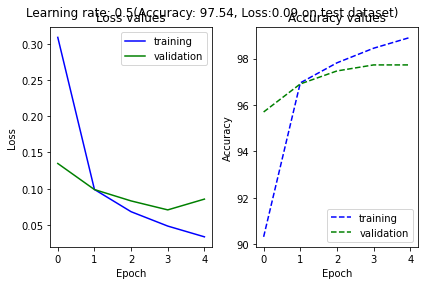

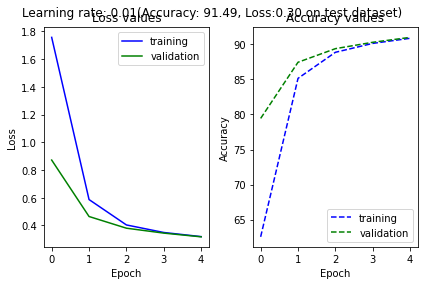

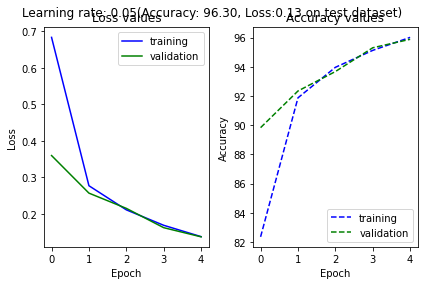

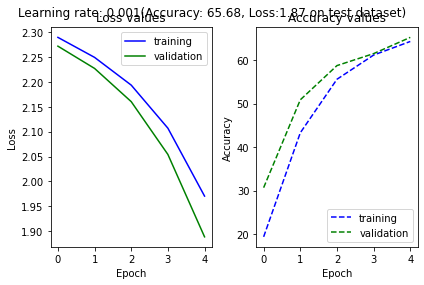

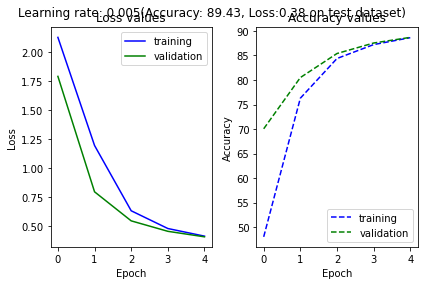

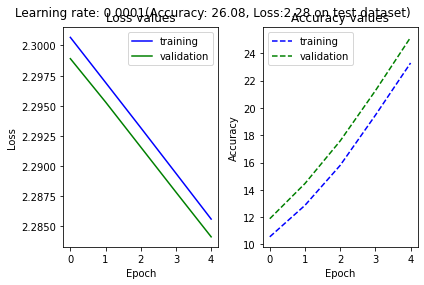

In [128]:
max_acc = 0

for learning_rate in [0.5, 0.01, 0.05, 0.001, 0.005, 0.0001]:
  # default values are taken from IntroductionToPyTorch example
  default_model = DefaultNeuralNetwork().to(device)
  default_loss_func = torch.nn.CrossEntropyLoss()
  default_optimizer = torch.optim.SGD(default_model.parameters(), lr=1e-3)
  default_optimizer = torch.optim.SGD(default_model.parameters(), lr=learning_rate)
  default_epochs = 5

  _, acc = train_model(default_model, training_dataloader, validation_dataloader, testing_dataloader, default_loss_func, default_optimizer, default_epochs)
  if acc > max_acc:
    max_acc = acc
    ret_vals = (default_model, training_dataloader, validation_dataloader, testing_dataloader, default_loss_func, default_optimizer, default_epochs)
print(ret_vals)